In [ ]:
DATA_FPATH = '/nfs_home/craigher/scratch/riboclette/results/interpretability/241001_RDHPLG_int.h5'
FA_FPATH = '/net/lts2gdk0/mnt/scratch/lts2/nallapar/rb-prof/data/Jan_2024/Lina/reference/ensembl.cds.fa'
GC_FPATH = '../data/genetic_code.csv'

In [ ]:
import sklearn as skl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import trange, tqdm
from Bio import SeqIO
import re
import seaborn as sns
import PyComplexHeatmap as pch
from numba import njit

# Load Genetic Code DataFrame

In [ ]:
genetic_code = pd.read_csv(GC_FPATH, index_col=0).set_index('Codon')
genetic_code.head()

# Load Gene to Sequence DataFrame

In [ ]:
df_trans_to_seq = []
with open(FA_FPATH, mode="r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        df_trans_to_seq.append([record.id, str(record.seq), record.description.split("gene_symbol:")[1].split()[0]])

df_trans_to_seq = pd.DataFrame(df_trans_to_seq, columns=["transcript", "sequence", "symbol"])
df_trans_to_seq.head()

# Define Conditions

In [ ]:
conditions = ['ILE', 'LEU', 'LEU_ILE', 'LEU_ILE_VAL', 'VAL', 'CTRL']

# Print h5 Keys

In [159]:
with h5py.File(DATA_FPATH, 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['condition', 'gene', 'lig_ctrl', 'lig_dd', 'lxg_ctrl', 'lxg_dd', 'transcript', 'x_input', 'y_pred_ctrl', 'y_pred_depr_diff', 'y_pred_full', 'y_true_ctrl', 'y_true_dd', 'y_true_full']>


# Define Weldford algorithm to compute running mean and std

In [ ]:
import math
from numba import jit

class Welford(object):
    """ Implements Welford's algorithm for computing a running mean
    and standard deviation as described at: 
        http://www.johndcook.com/standard_deviation.html

    can take single values or iterables

    Properties:
        mean    - returns the mean
        std     - returns the std
        meanfull- returns the mean and std of the mean

    Usage:
        >>> foo = Welford()
        >>> foo(range(100))
        >>> foo
        <Welford: 49.5 +- 29.0114919759>
        >>> foo([1]*1000)
        >>> foo
        <Welford: 5.40909090909 +- 16.4437417146>
        >>> foo.mean
        5.409090909090906
        >>> foo.std
        16.44374171455467
        >>> foo.meanfull
        (5.409090909090906, 0.4957974674244838)
    """

    def __init__(self, lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        
        self.__call__(lst)
    
    @staticmethod
    @jit(nopython=True)
    def update_numba(k, M, S, x):
        k += 1
        newM = M + (x - M) * 1.0 / k
        newS = S + (x - M) * (x - newM)
        return k, newM, newS

    def update(self, x):
        if x is None:
            return
        self.k, self.M, self.S = self.update_numba(self.k, self.M, self.S, x)

    def consume(self, lst):
        for x in lst:
            self.update(x)
    
    def __call__(self, x):
        if hasattr(x, "__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M

    @property
    def meanfull(self):
        return self.mean, self.std / math.sqrt(self.k)

    @property
    def std(self):
        if self.k == 1:
            return 0
        return math.sqrt(self.S / (self.k - 1))

    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)


# Compute Statistics for CTRL Head

In [ ]:
# topk = 5
# attr_type = 'lig'
# condition_freq_ctrl_head = {cond: {cod: 0 for cod in genetic_code.index} for cond in conditions}
# with h5py.File(DATA_FPATH, 'r') as f:
#     transcripts = f['transcript'][:].astype('U') 
#     conditions = f['condition'][:].astype('U') 
#     for transc_idx in trange(transcripts.shape[0]):
#         transcript = transcripts[transc_idx]
#         condition = conditions[transc_idx]
#         trasc_attr = f[f'{attr_type}_ctrl'][transc_idx]
#         n_codons = int(np.sqrt(trasc_attr.shape[0]))
#         trasc_attr = trasc_attr.reshape(n_codons, n_codons)
#         sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
#         sequence = np.array(re.findall('...', sequence))
#         for top_codon in np.argsort(trasc_attr, 1)[:,-topk:].flatten():
#             condition_freq_ctrl_head[condition][sequence[top_codon]] += 1

# condition_freq_ctrl_head = pd.DataFrame(condition_freq_ctrl_head)
# condition_freq_ctrl_head = condition_freq_ctrl_head / condition_freq_ctrl_head.sum(0)


In [ ]:
# wsize = 20
# condition_attr_ctrl_head = {cond: {cod: Welford() for cod in genetic_code.index} for cond in conditions}
# with h5py.File(DATA_FPATH, 'r') as f:
#     transcripts = f['transcript'][:].astype('U') 
#     depr_true = f['y'][:].astype('U') 
#     conditions = f['condition'][:].astype('U') 
#     for transc_idx in trange(transcripts.shape[0]):
#         transcript = transcripts[transc_idx]
#         condition = conditions[transc_idx]
#         trasc_attr = f['attributions_ctrl'][transc_idx]
#         n_codons = int(np.sqrt(trasc_attr.shape[0]))
#         trasc_attr = trasc_attr.reshape(n_codons, n_codons)     
#         sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
#         sequence = np.array(re.findall('...', sequence))
#         for idx in np.arange(wsize, n_codons-wsize):
#             wattr = trasc_attr[idx,idx-wsize:idx+wsize+1]
#             wattr = np.abs(wattr)
#             wattr = wattr / wattr.sum()
#             for attr_idx, codon_idx in enumerate(np.arange(idx-wsize, idx+wsize+1)):
#                 condition_attr_ctrl_head[condition][sequence[codon_idx]](wattr[attr_idx])

In [ ]:
# condition_attr_ctrl_head_comp = {cond: {cod: w.mean for cod, w in cod_wise.items()} for cond, cod_wise in condition_attr_ctrl_head.items()}

In [ ]:
# pd.DataFrame(condition_attr_ctrl_head_comp)

In [ ]:
# plt.figure(figsize=(30, 3))

# cmap = plt.get_cmap('tab20c')
# colors = np.array(cmap.colors)
# np.random.seed(42)
# np.random.shuffle(colors)
# randomized_cmap = plt.matplotlib.colors.ListedColormap(colors)

# col_ha = pch.HeatmapAnnotation(aminoacid=pch.anno_simple(genetic_code, add_text=True,legend=False,text_kws={'fontsize':10, 'color':'black'},cmap=randomized_cmap, height=5),axis=1)
# pch.ClusterMapPlotter(
#     data=pd.DataFrame(condition_attr_ctrl_head_comp).T,
#     col_split=genetic_code, col_split_gap=1,
#     top_annotation=col_ha,
#     annot=True, 
#     fmt='.2f',
#     cmap='coolwarm',
#     show_rownames=True,show_colnames=True,
#     col_cluster=False,row_cluster=False,
#     xticklabels_kws=dict(labelrotation=-45))
# plt.suptitle('Distribution of TOP5 attributions in the ctrl head, by condition')
# #plt.savefig('plots/top5_attr_ctrl_head.png', dpi=400, bbox_inches='tight')

In [ ]:
# topk = 5
# condition_freq_depr_head = {cond: {cod: 0 for cod in genetic_code.index} for cond in conditions if cond != 'CTRL'}
# with h5py.File(DATA_FPATH, 'r') as f:
#     transcripts = f['transcript'][:].astype('U') 
#     conditions = f['condition'][:].astype('U') 
#     for transc_idx in trange(transcripts.shape[0]):
#         condition = conditions[transc_idx]
#         if condition == 'CTRL':
#             continue
#         transcript = transcripts[transc_idx]
#         trasc_attr = f[f'{attr_type}_dd'][transc_idx]
#         n_codons = int(np.sqrt(trasc_attr.shape[0]))
#         trasc_attr = trasc_attr.reshape(n_codons, n_codons)
#         sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
#         sequence = np.array(re.findall('...', sequence))
#         for top_codon in np.argsort(trasc_attr, 1)[:,-topk:].flatten():
#             condition_freq_depr_head[condition][sequence[top_codon]] += 1

# condition_freq_depr_head = pd.DataFrame(condition_freq_depr_head)
# condition_freq_depr_head = condition_freq_depr_head / condition_freq_depr_head.sum(0)


# Compute Statistics for Deprivation Head

In [14]:
wsize = 20
attr_type = 'lig'
ensembl_to_remove = ('145167.7')

In [20]:
# Store Weldford datastructure for each combination of codon and condition
condition_freq_depr_head = {cond: {cod: Welford() for cod in genetic_code.index} for cond in conditions if cond != 'CTRL'}
# Store count statistics for each combination of codon and condition
condition_count_depr_head = {cond: {cod: 0 for cod in genetic_code.index} for cond in conditions if cond != 'CTRL'}

with h5py.File(DATA_FPATH, 'r') as f:
    transcripts = f['transcript'][:].astype('U') 
    conditions = f['condition'][:].astype('U') 

    # Loop throught transcripts
    for transc_idx in trange(transcripts.shape[0]):
        condition = conditions[transc_idx]

        # Exclude control condition
        if condition == 'CTRL':
            continue

        transcript = transcripts[transc_idx]

        # Remove bad samples
        if df_trans_to_seq.query('transcript == @transcript').transcript.str.endswith(ensembl_to_remove).values[0]:
            continue

        # Get attribution vector and reshape to matrix
        trasc_attr = f[f'{attr_type}_dd'][transc_idx]
        n_codons = int(np.sqrt(trasc_attr.shape[0]))
        trasc_attr = trasc_attr.reshape(n_codons, n_codons)

        # Get sequence
        sequence = df_trans_to_seq.query('transcript == @transcript').sequence.values[0]
        sequence = np.array(re.findall('...', sequence))

        #depr_true = f['y_true_dd'][transc_idx]
        #threshold = np.nanquantile(np.abs(depr_true), .9)
        #good_idxs = np.nonzero(np.abs(depr_true) > threshold)[0]
        #good_idxs = good_idxs[(good_idxs>=wsize) & (good_idxs < n_codons-wsize-1)]

        # Loop through the sequence, excluding a prefix and suffix of wsize and wsize+1, respectively
        for idx in np.arange(wsize, n_codons-wsize-1):
        #for idx in np.arange(n_codons-1):
            #wattr = trasc_attr[idx]
            wattr = trasc_attr[idx,idx-wsize:idx+wsize+1]
            wattr = np.abs(wattr)
            wattr = wattr / wattr.sum()
            for attr_idx, codon_idx in enumerate(np.arange(idx-wsize, idx+wsize+1)):
            #for attr_idx, codon_idx in enumerate(np.arange(n_codons-1)):
                condition_freq_depr_head[condition][sequence[codon_idx]](wattr[attr_idx])
                condition_count_depr_head[condition][sequence[codon_idx]] += 1

condition_freq_depr_head = {cond: {cod: w.mean for cod, w in cod_wise.items()} for cond, cod_wise in condition_freq_depr_head.items()}
condition_freq_depr_head = pd.DataFrame(condition_freq_depr_head)

  0%|          | 0/4252 [00:00<?, ?it/s]

In [ ]:
# plt.figure(figsize=(30, 3))

# cmap = plt.get_cmap('tab20c')
# colors = np.array(cmap.colors)
# np.random.seed(42)
# np.random.shuffle(colors)
# randomized_cmap = plt.matplotlib.colors.ListedColormap(colors)

# col_ha = pch.HeatmapAnnotation(aminoacid=pch.anno_simple(genetic_code, add_text=True,legend=False,text_kws={'fontsize':10, 'color':'black'},cmap=randomized_cmap, height=5),axis=1)
# pch.ClusterMapPlotter(
#     data=condition_freq_depr_head.T,
#     col_split=genetic_code, col_split_gap=1,
#     top_annotation=col_ha,
#     annot=True, 
#     fmt='.2f',
#     cmap='coolwarm',
#     show_rownames=True,show_colnames=True,
#     col_cluster=False,row_cluster=False,
#     xticklabels_kws=dict(labelrotation=-45),
#     row_cluster_metric='euclidean', col_cluster_metric='euclidean')
# plt.suptitle('Distribution of TOP5 attributions in the deprivation head, by condition')
# plt.savefig('../results/plots/top5_attr_depr_head.pdf', dpi=400, bbox_inches='tight')

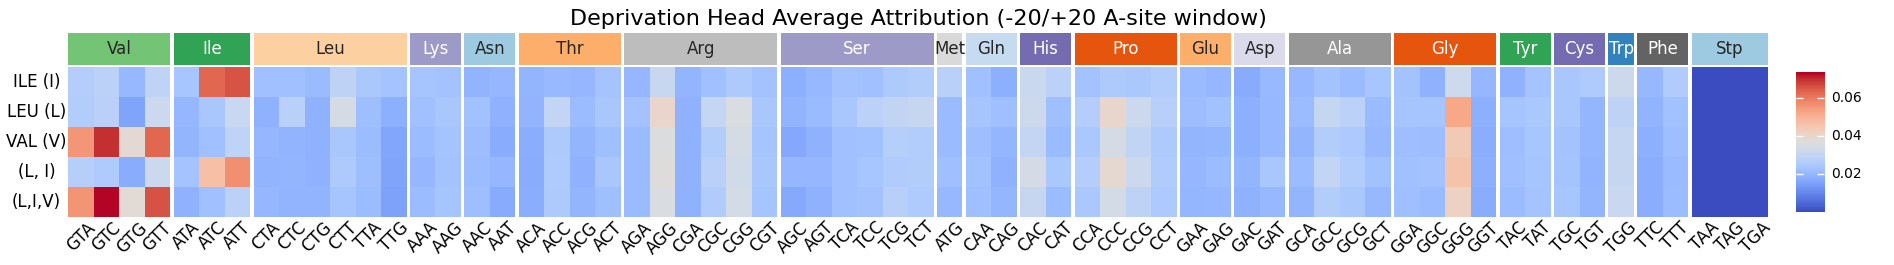

In [158]:
import marsilea as ma

AA = ['Val', 'Ile', 'Leu', 'Lys', 'Asn', 'Thr', 'Arg', 'Ser', 'Met', 'Gln', 'His', 'Pro', 'Glu', 'Asp', 'Ala', 'Gly', 'Tyr', 'Cys', 'Trp', 'Phe', 'Stp']
DEPR_NAMES = {'ILE':'ILE (I)', 'LEU':'LEU (L)', 'VAL':'VAL (V)', 'LEU_ILE':'(L, I)', 'LEU_ILE_VAL':'(L,I,V)'}
data = condition_freq_depr_head.rename(columns=DEPR_NAMES).reindex(columns=DEPR_NAMES.values())
h = ma.Heatmap(data.T, width=17, height=1.5)

cmap = plt.get_cmap('tab20c')
colors = np.array(cmap.colors).repeat(2,0)
np.random.seed(42)
np.random.shuffle(colors)

h.group_cols(genetic_code.AminoAcid, spacing=0.002, order=AA)
h.add_top(
        ma.plotter.Chunk(
            AA,
            colors[:len(AA)],
            padding=10,
            fontsize=12
        ),
        pad=0.025
    )
h.add_bottom(ma.plotter.Labels(data.index, rotation=45,fontsize=12), name='Codon')
h.add_left(ma.plotter.Labels(data.columns,align='center',fontsize=12), name='Deprivation')
h.add_legends()
h.add_title("Deprivation Head Average Attribution (-20/+20 A-site window)",fontsize=16)
h.render()
plt.savefig('../results/plots/window_depr_head.pdf', dpi=300, bbox_inches='tight')